# 机器学习：用Python预测你是否是灾难中的幸存者

1912年英国白星航运公司下辖的巨轮泰坦尼克号，在从南安普敦驶向美国纽约的途中与一座冰山相撞，造成右舷船艏至船舯部破裂，五座水密舱进水。最终泰坦尼克船体断裂成两截后沉入大西洋底3700米处，2224名船员及乘客中，逾1500人丧生。

![Titanic](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/1024px-RMS_Titanic_3.jpg)

本文将和大家一起穿越百年，再回到泰坦尼克号沉船事故发生的现场。看看你我是否能成为这场灾难的幸存者？

*本文采用真实数据，数据来源于 [kaggle](https://www.kaggle.com/c/titanic)*

**本次训练数据，采用泰坦尼克号中891名乘客的人口学数据和基本信息。**
**测试数据，采用泰坦尼克号中其余418名乘客的数据**

In [1]:
# 引用数据分析需要使用的一些包

# 数据规整化
import pandas as pd
from pandas import Series,DataFrame
from collections import Counter
import numpy as np
import re

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# 机器学习
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

c:\users\administrator\appdata\local\programs\python\python36-32\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# 读取数据集

titanic_data = pd.read_csv('train.csv')
titanic_test_data = pd.read_csv('test.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


数据中包含的信息：

- Survived => 是否生还 
    - *0 = No, 1 = Yes*
- Pclass => 乘客等级(1/2/3等舱位)
- Name => 乘客姓名
- Sex => 性别
- Age => 年龄
- SibSp => 堂兄弟/妹个数
- Parch => 父母与小孩个数
- Ticket => 船票信息
- Fare => 票价
- Cabin => 客舱
- Embarked => 登船港口 
    - *C = Cherbourg 瑟堡, Q = Queenstown 皇后镇, S = Southampton 南安普普顿*

In [3]:
# 查看数据的整体信息

titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [4]:
# 查看数据的摘要信息

titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


从整体信息与摘要信息中我们获得了什么？

1. 891名乘客及船员的信息比较完整，其中 *age* 字段以及 *embarked* 有缺失值。
2. 891名乘客中生还率为 38.38%

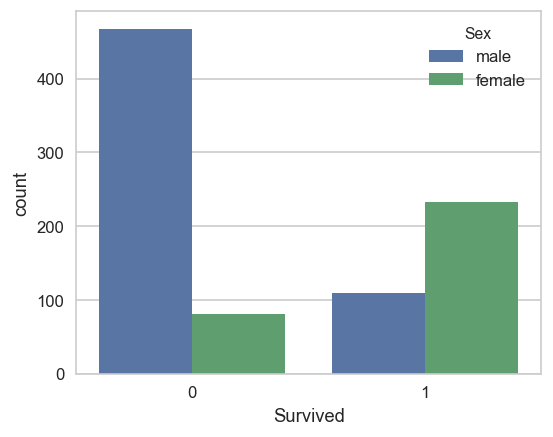

In [5]:
fig = plt.figure(figsize=(5,4), dpi=120)
ax = fig.add_subplot(111)
ax = sns.countplot('Survived',data=titanic_data,hue='Sex')

In [8]:
titanic_data = titanic_data.fillna(method='ffill') # 填补数据缺失值
titanic_data.groupby(['Survived','Sex']).count()[['PassengerId']]

PassengerId
Survived Sex                
0        female           81
         male            468
1        female          233
         male            109

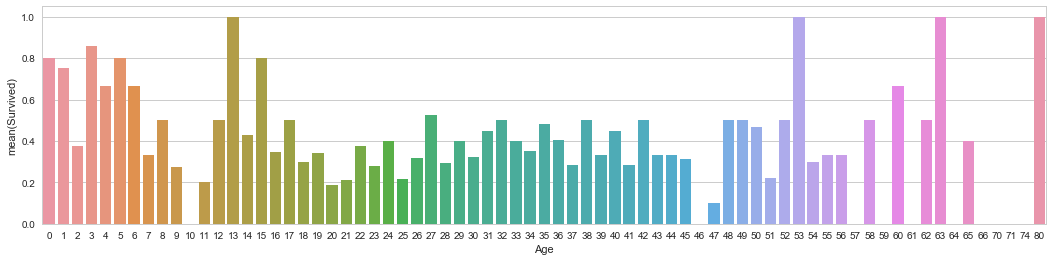

In [9]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
titanic_data.Age = titanic_data.Age.apply(int)
average_age = titanic_data[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
ax = sns.barplot(x='Age', y='Survived', data=average_age)

这每一条冰冷的数据背后，都是一个真实存在的人。我们先聚焦这些数据背后鲜活的生命，来看看这些数据背后的故事。

泰坦尼克号中有一些比较有名气的人，让我们来看看他们在这场灾难中经历了什么？

1. John Jacob Astor IV，百万富翁、投资家和作家，是泰坦尼克号中最富有的人。
2. 美国梅西百货股东 Isidor Straus。

In [10]:
# 通过姓氏查找人物数据的方法

def find_people(df,lastname):
    name_list = []
    for index,names in enumerate(df.Name.values):
         if lastname in names.split(',')[0]:
                name_list.append(df.iloc[index])
    return name_list

# 找到约翰·雅各布·阿斯特四世

print(find_people(titanic_data,'Astor')) # 训练数据中的Astor
print('--------')
print(find_people(titanic_test_data,'Astor')) # 测试数据中的Astor

[PassengerId                                                  701
Survived                                                       1
Pclass                                                         1
Name           Astor, Mrs. John Jacob (Madeleine Talmadge Force)
Sex                                                       female
Age                                                           18
SibSp                                                          1
Parch                                                          0
Ticket                                                  PC 17757
Fare                                                     227.525
Cabin                                                    C62 C64
Embarked                                                       C
Name: 700, dtype: object]
--------
[PassengerId                      1094
Pclass                              1
Name           Astor, Col. John Jacob
Sex                              male
Age                            

我们找到的第一个人，她的全名（'Name字段'）叫做*Astor, Mrs. John Jacob*，从名字中可以断定她是*约翰·雅各布*的妻子。
我们找到的第二个人，他的全名叫做*Astor, Col. John Jacob*，这个人就是我们要找的找到约翰·雅各布·阿斯特四世。

![](https://upload.wikimedia.org/wikipedia/commons/9/91/John_Jacob_Astor_1909.jpg)
约翰·雅各布

约翰·雅各布和他的妻子相差29岁，他们花了227英镑买下了两张泰坦尼克号一等舱的船票，并且在英吉利海峡的瑟堡港口登船开始蜜月之旅。然而不幸发生了，这艘巨轮将要沉没，在这场灾难中这对夫妻会有怎样的结局？

通过数据我们知道约翰·雅各布的妻子劫后余生（*Survived =1*），而雅各布先生本人的生还情况我们还不知道，不过我们可以通过Python机器学习来帮助我们找到故事的结局。

In [11]:
# 找到 Isidor Straus

find_people(titanic_test_data,'Straus')

[PassengerId                   973
 Pclass                          1
 Name           Straus, Mr. Isidor
 Sex                          male
 Age                            67
 SibSp                           1
 Parch                           0
 Ticket                   PC 17483
 Fare                      221.779
 Cabin                     C55 C57
 Embarked                        S
 Name: 81, dtype: object, PassengerId                                      1006
 Pclass                                              1
 Name           Straus, Mrs. Isidor (Rosalie Ida Blun)
 Sex                                            female
 Age                                                63
 SibSp                                               1
 Parch                                               0
 Ticket                                       PC 17483
 Fare                                          221.779
 Cabin                                         C55 C57
 Embarked                               

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Isidor_Straus_1903.jpg/220px-Isidor_Straus_1903.jpg)

美国梅西百货股东*Isidor Straus*和他的妻子，花费了221英镑卖了泰坦尼克号的一等舱舱位。他们在南安普顿港口登船，最终生死未卜。但我们可以通过Python来看看这两位老夫妻的结局。

我们聚焦于这些冰冷数据后的鲜活个体后，我们再来看看那些在泰坦尼克号中的一家人，在灾难发生后有了怎样的变故？

In [12]:
# 寻找泰坦尼克号中的家庭

def get_family_lastname():
    lname_list = []
    fn = titanic_data.Name[titanic_data['SibSp'] >= 1] # 同辈亲戚人数大于1的乘客
    fl = [name.split(',')[0] for name in fn.values] # 这些乘客的姓氏列表
    fs = set(fl) # 对姓氏列表进行去重
    # 确定为训练数据集中的家庭
    for lname in fs:
        if len(find_people(titanic_data,lname)) >= 2:
            lname_list.append(lname)
    return lname_list

# 在灾难发生后家庭成员存活状况

def family_info(family_lastname):
    name_list = find_people(titanic_data,family_lastname) # 所有家庭成员
    f_info = []
    for i in name_list:
        info = {}
        info['lname'],info['fname'] = i.Name.split(',')
        info['sex'] = i.Sex
        info['Age'] = i.Age
        info['Pclass'] = i.Pclass
        info['Survived'] = i.Survived
        f_info.append(info)
    family_df = DataFrame(f_info) # 构建一个数组
    return family_df

In [13]:
# 全部家庭的数组

all_family_df_list = []
for l in get_family_lastname():
    all_family_df_list.append(family_info(l))
all_family_df = pd.concat(all_family_df_list)

In [14]:
all_family_df.head()

,Age,Pclass,Survived,fname,lname,sex
0,36,2,0,"Mr. Michel (""Louis M Hoffman"")",Navratil,male
1,3,2,1,Master. Michel M,Navratil,male
2,2,2,1,Master. Edmond Roger,Navratil,male
0,36,3,0,Mr. Ingvald Olai Olsen,Hagland,male
1,9,3,0,Mr. Konrad Mathias Reiersen,Hagland,male


我们先来看看有多少人和自己的家人一起登上了泰坦尼克号？

In [15]:
f_c = len(Counter(all_family_df.lname))
print('在泰坦尼克号中共有{}个家庭'.format(f_c))
family_member_count = all_family_df['fname'].groupby(all_family_df['lname']).count()

在泰坦尼克号中共有106个家庭


In [16]:
# 找到家庭成员最多的家庭

family_member_count[family_member_count == family_member_count.max()]

lname
Andersson    9
Name: fname, dtype: int64

在106个家庭中，其中*Andersson*安德森家族共有9名家族成员登船，我们来看看这个家庭在灾难中发生了什么？

In [17]:
all_family_df[all_family_df.lname == 'Andersson']

,Age,Pclass,Survived,fname,lname,sex
0,39,3,0,Mr. Anders Johan,Andersson,male
1,17,3,1,Miss. Erna Alexandra,Andersson,female
2,2,3,0,Miss. Ellis Anna Maria,Andersson,female
3,27,3,1,"Mr. August Edvard (""Wennerstrom"")",Andersson,male
4,9,3,0,Miss. Ingeborg Constanzia,Andersson,female
5,11,3,0,Miss. Sigrid Elisabeth,Andersson,female
6,39,3,0,Mrs. Anders Johan (Alfrida Konstantia Brogren),Andersson,female
7,6,3,0,Miss. Ebba Iris Alfrida,Andersson,female
8,4,3,0,Master. Sigvard Harald Elias,Andersson,male


*Andersson*家族中的一共有五个小孩子，其中有一个小男孩和四个小女孩。不幸的是这五个小孩子都在这场灾难中丧生了。他们中最小的只有两岁，最大的也不过11岁。

另外的四个大人，分别是*Anders Johan*夫妇和两个年轻人欧娜女士和爱德华先生。*Anders Johan*夫妇在这场灾难中共赴生死，而这两个年轻人活了下来。

在这场巨大的灾难中，一个九人组成的大家庭只有两个人幸运的活了下来，而其他七个只能随着泰坦尼克号坠入大西洋。

家庭的惨剧已然让我们悲伤不已，恋人之间的生离死别、阴阳相隔更是令人唏嘘感叹。在目睹了家庭的惨剧后，我们再来看看泰坦尼克号中的情侣们最后的结局！

In [18]:
r = re.compile(r'Mrs.(.*?)\(') # 通过正则表达式获取丈夫姓氏
husband_name = [] # 丈夫姓名列表
for l in all_family_df.fname:
    n = r.findall(l)
    if n:
        n = n[0].strip()
        husband_name.append(n)

In [19]:
# 排除同名的可能

def husband_and_wife(name):
    haw_df = all_family_df[[True if name in n else False for n in all_family_df.fname]]
    if len(haw_df) >= 2:
        return haw_df
    pass

In [20]:
# 判断家庭情况

def faw_situation(name):
    faw = husband_and_wife(name)
    faw_g_c = faw.groupby('lname').count()
    faw_list = faw_g_c[faw_g_c.sex >= 2].index
    faw_g_s = faw.groupby('lname').sum()
    situation = []
    for i in faw_list:
        f_c = faw_g_c.loc[i,'Age']
        s = faw_g_s.loc[i,'Survived']
        if s == 0:
            situation.append(('{} {} 夫妇'.format(i,name),'All dead'))
        elif s == f_c:
            situation.append(('{} {} 夫妇'.format(i,name),'All alive'))
        else:
            for p_info in find_people(titanic_data,i):
                if name in p_info.Name:
                    if p_info.Survived == 0:
                        if p_info.Sex == 'female':
                            situation.append(('{} {} 夫妇'.format(i,name),'wife dead'))
                            break
                        else:
                            situation.append(('{} {} 夫妇'.format(i,name),'husband dead'))
                            break
    if situation:
        return situation

In [21]:
faw_situ_list = [] # 家庭情况列表
for n in husband_name:
    if husband_and_wife(n) is not None:
        if faw_situation(n):
            faw_situ_list += faw_situation(n)
faw_situ_list[:5] # 只读取前5个数据

[('Nasser Nicholas 夫妇', 'husband dead'),
 ('Taussig Emil 夫妇', 'husband dead'),
 ('Goldenberg Samuel L 夫妇', 'All alive'),
 ('Collyer Harvey 夫妇', 'husband dead'),
 ('Panula Juha 夫妇', 'All dead')]

In [22]:
f_df = DataFrame(faw_situ_list,columns=['family','Dead or Alive'])
f_df.groupby('Dead or Alive').count()

,family
Dead or Alive,
All alive,21
All dead,18
husband dead,45


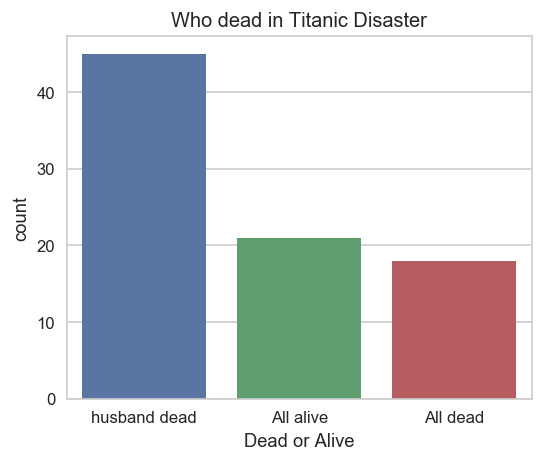

In [23]:
fig = plt.figure(figsize=(5,4), dpi=120)
ax = fig.add_subplot(111)
ax = sns.countplot('Dead or Alive',data=f_df)
ax.set_title('Who dead in Titanic Disaster')

泰坦尼克号中共有84对夫妻，其中18对夫妻共赴死亡，21对夫妻一起好了下来。

而另54对夫妻中，他们在生死的抉择中都选择让妻子活下来。**问世间情为何物，直教人生死相许！**